In [1]:
import numpy as np
import matplotlib.pyplot as plt
from intern import array
from pathlib import Path
from PIL import Image
from skimage import feature, future
from functools import partial

In [2]:
X_PATH = Path("/Users/mateljk1/Documents/projects/tanis/data/Paddlefish 43.53 um/Paddlefish scanned at 43.53 um")
Y_PATH = Path("/Users/mateljk1/Documents/projects/tanis/data/Paddlefish 43.53 um/Bones 43.53 um/")

SKIP = 4

IMAGES = list(sorted(X_PATH.glob("*.jp2")))
LABELS = list(sorted(Y_PATH.glob("*.jpg")))

def get_image(z: int) -> np.array:
    return np.array(Image.open(IMAGES[z]))[::SKIP,::SKIP]

def get_label(z: int) -> np.array:
    return (np.array(Image.open(LABELS[z])) > 5).astype(int)[::SKIP,::SKIP]

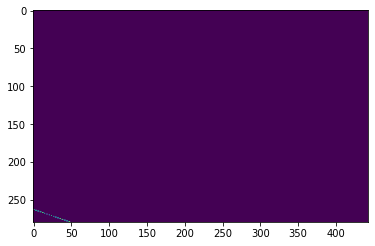

In [3]:
plt.imshow(get_label(2))

In [4]:
# Features
sigma_min = 1
sigma_max = 16
features_func = partial(
    feature.multiscale_basic_features,
    intensity=True,
    edges=True,
    texture=True,
    sigma_min=sigma_min,
    sigma_max=sigma_max,
)

In [5]:
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

In [6]:
SAMPLE_K = 100

# Training
# X = np.array([features_func(get_image(z)) for z in tqdm(range(SAMPLE_K))])
X = np.array(
    Parallel(n_jobs=-1)(
        delayed(features_func)(get_image(z)) for z in tqdm(range(SAMPLE_K))
    )
)
y = np.array([get_label(z) for z in range(SAMPLE_K)]).astype(int)


  0%|          | 0/100 [00:00<?, ?it/s]

In [7]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=10, n_jobs=-1, verbose=1)
rf.fit(X_train.reshape(-1, X_train.shape[-1]), y_train.reshape(-1))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


KeyboardInterrupt: 

In [ ]:
# Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = rf.predict(X_test.reshape(-1, X_test.shape[-1])).reshape(y_test.shape)
print(accuracy_score(y_test.reshape(-1), y_pred.reshape(-1)))
# print(confusion_matrix(y_test.reshape(-1), y_pred.reshape(-1)))

# Draw confusion matrix with labels:
# https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(
    cm, classes,
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.5f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



0.9873873873873874


Normalized confusion matrix
[[9.99225028e-01 7.74971671e-04]
 [9.97291441e-01 2.70855905e-03]]


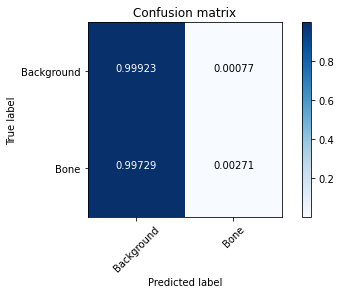

In [ ]:
plot_confusion_matrix(
    confusion_matrix(y_test.reshape(-1), y_pred.reshape(-1)),
    classes=['Background', 'Bone'],
    normalize=True,
)

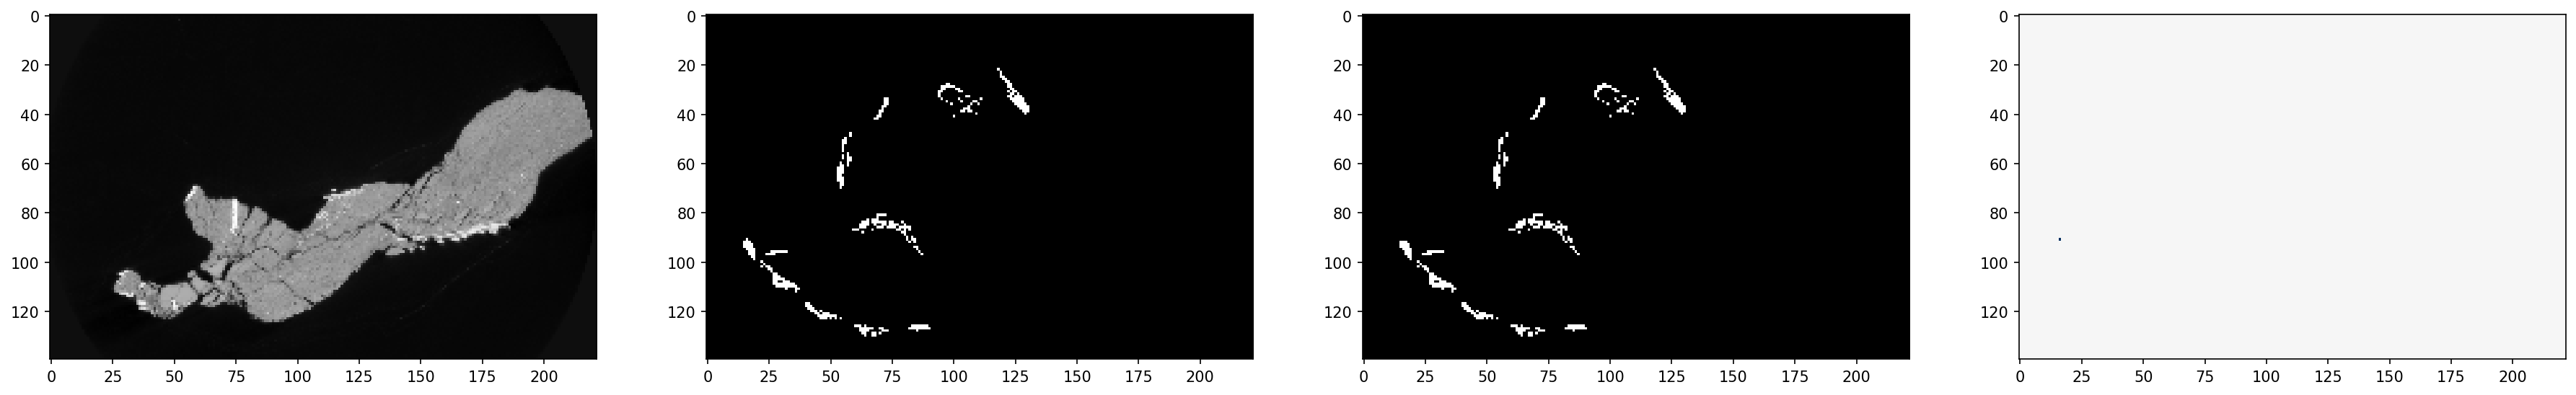

In [ ]:
# A 1-row, 4-column grid of subplots
# * The first column is the original image
# * The second column is the ground truth
# * The third column is the prediction
# * The fourth column is the difference between the ground truth and the prediction
zslice = 2

pred_zslice = rf.predict(features_func(get_image(zslice)).reshape(-1, X_train.shape[-1])).reshape(y_test.shape[1:])

fig, axs = plt.subplots(1, 4, figsize=(30, 30), dpi=150)
axs[0].imshow(get_image(zslice), cmap='gray')
axs[1].imshow(get_label(zslice), cmap='gray')
axs[2].imshow(pred_zslice, cmap='gray', )
axs[3].imshow(get_label(zslice) - pred_zslice, cmap='RdBu', vmin=-1, vmax=1)


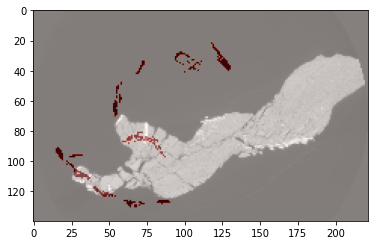

In [ ]:
plt.imshow(get_image(2), cmap='gray')
plt.imshow(get_label(2), cmap='Reds', alpha=0.5)